# Trading Gym Example

In this example I'll show how to use this gym with few basic agents implemenations.

In [1]:
import warnings

import gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt

from gym_trading.envs.data_loader import ListDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PlotRenderer
from gym_trading.envs.rewards import ProfitRewarder
from gym_trading.envs.chart import ChartDataFrame

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

First of all we need data to populate the environment.
We can download bitcoin chart from [coingecko.com](coingecko.com).

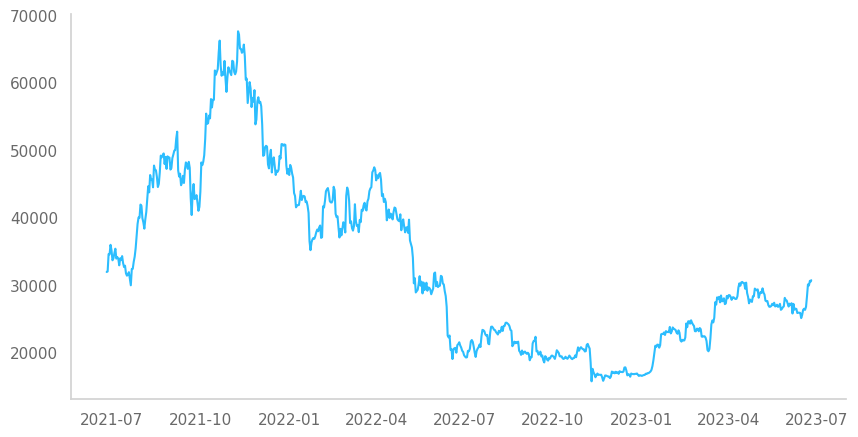

In [2]:
# Make an API call to get Bitcoin price data
url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
params = {
    'vs_currency': 'usd',
    'days': '730',
}
response = requests.get(url, params=params)
data = response.json()

# Extract dates and prices from the API response
timestamps = data['prices']
dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
prices = [price for _, price in timestamps]

plt.plot(dates, prices)
plt.show()

Here we create the gym. It allows us to configure:
- the data loader,
- the exchange behavior,
- the rewarder and
- the window size of the observations.

In practice, the environment will scan the data generated by the data loader. At each step, it will return to the agent an observation with the *n* last values until the *current day* (= day of iteration in the simulation).
The agent will play an action: BUY, SELL or HOLD and the environment will update the internal state, returning the reward computed by the defined rewarder.

In [3]:
# creating environment
env = gym.make(
    'gym_trading:trading-v0',
    data_loader=ListDataLoader(dates=dates, values=prices),
    exchange=BaseExchange(init_amount=100.0, buy_fee=0.25, sell_fee=0.25),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
    observation_window_size=50
)

Here we can see an example of observation

In [4]:
print('Number of actions:', env.action_space.n)

# resetting environment
observation = env.reset()[0]
print(f'Observation:\n{observation}')
print(f'{observation.shape = }')
print(f'{type(observation) = }')

Number of actions: 3
Observation:
         DATE         VALUE
0  2021-06-26  31943.136468
1  2021-06-27  32023.973902
2  2021-06-28  34607.293274
3  2021-06-29  34556.842127
4  2021-06-30  35968.993668
5  2021-07-01  35171.486305
6  2021-07-02  33677.566236
7  2021-07-03  33950.786555
8  2021-07-04  34729.890778
9  2021-07-05  35394.213074
10 2021-07-06  33928.134218
11 2021-07-07  34149.989815
12 2021-07-08  33932.254638
13 2021-07-09  32933.578199
14 2021-07-10  33971.297750
15 2021-07-11  33704.538474
16 2021-07-12  34299.938017
17 2021-07-13  33262.654352
18 2021-07-14  32676.383801
19 2021-07-15  32878.501874
20 2021-07-16  31726.038834
21 2021-07-17  31399.653129
22 2021-07-18  31588.671351
23 2021-07-19  31919.393923
24 2021-07-20  30928.211909
25 2021-07-21  29971.903784
26 2021-07-22  32383.781127
27 2021-07-23  32409.499767
28 2021-07-24  33455.551273
29 2021-07-25  34213.599932
30 2021-07-26  35456.124661
31 2021-07-27  37281.918092
32 2021-07-28  39076.593771
33 2021-07-29 

## Agents

Now we can define our trading agents that can be used as baselines.

In [5]:
class Agent(ABC):

    @abstractmethod
    def action(self, observation: ChartDataFrame) -> str:
        pass

### Random Agent

To play random actions

In [6]:
class RandomAgent(Agent):
    def action(self, observation: ChartDataFrame) -> str:
        return np.random.choice(['BUY', 'SELL', 'HOLD'])

### Moving Average Crossover Agent

It buys when the short MA has a value higher then the long MA.

In [7]:
def calculate_moving_average(observation: ChartDataFrame, window: int) -> float:
    # Get the last 'window' values from the observation
    values = observation.values[-window:]

    # Calculate the moving average
    ma = sum(values) / len(values)
    return ma


class MovingAverageCrossoverAgent(Agent):
    def action(self, observation: ChartDataFrame) -> str:
        # Calculate the short-term and long-term moving averages
        short_ma = calculate_moving_average(observation, window=10)
        long_ma = calculate_moving_average(observation, window=50)

        if short_ma > long_ma:
            action = 'BUY'
        else:
            action = 'SELL'

        return action

### Bollinger Bands Agent

In [8]:
class BollingerBandsAgent(Agent):
    def action(self, observation: ChartDataFrame) -> str:
        # Calculate the middle band and standard deviation of the values
        middle_band = calculate_moving_average(observation, window=20)
        std_dev = self.calculate_standard_deviation(observation, window=20)

        # Get the last value from the observation
        last_value = observation.values[-1]

        if last_value > middle_band + std_dev:
            action = 'SELL'
        elif last_value < middle_band - std_dev:
            action = 'BUY'
        else:
            action = 'HOLD'

        return action

    @staticmethod
    def calculate_standard_deviation(observation: ChartDataFrame, window: int) -> float:
        # Get the last 'window' values from the observation
        values = observation.values[-window:]

        # Calculate the standard deviation
        std_dev = (sum((x - calculate_moving_average(observation, window)) ** 2 for x in values) / len(
            values)) ** 0.5

        return std_dev


## Simulations

Here we define a method to run simulations based on the given agent.
It'll iterate on the given data, step by step, day by day, passing observations to the agents and playing actions provided by them.
In the end, it will plot the result.

In [9]:
def simulate(agent: Agent, env):
    print('Simulating a trading session with agent:', agent.__class__.__name__)
    observation = env.reset()[0]
    done = False
    while not done:
        action = agent.action(observation)
        observation, reward, done, truncated, _ = env.step(action)
    env.render()

Simulating a trading session with agent: RandomAgent


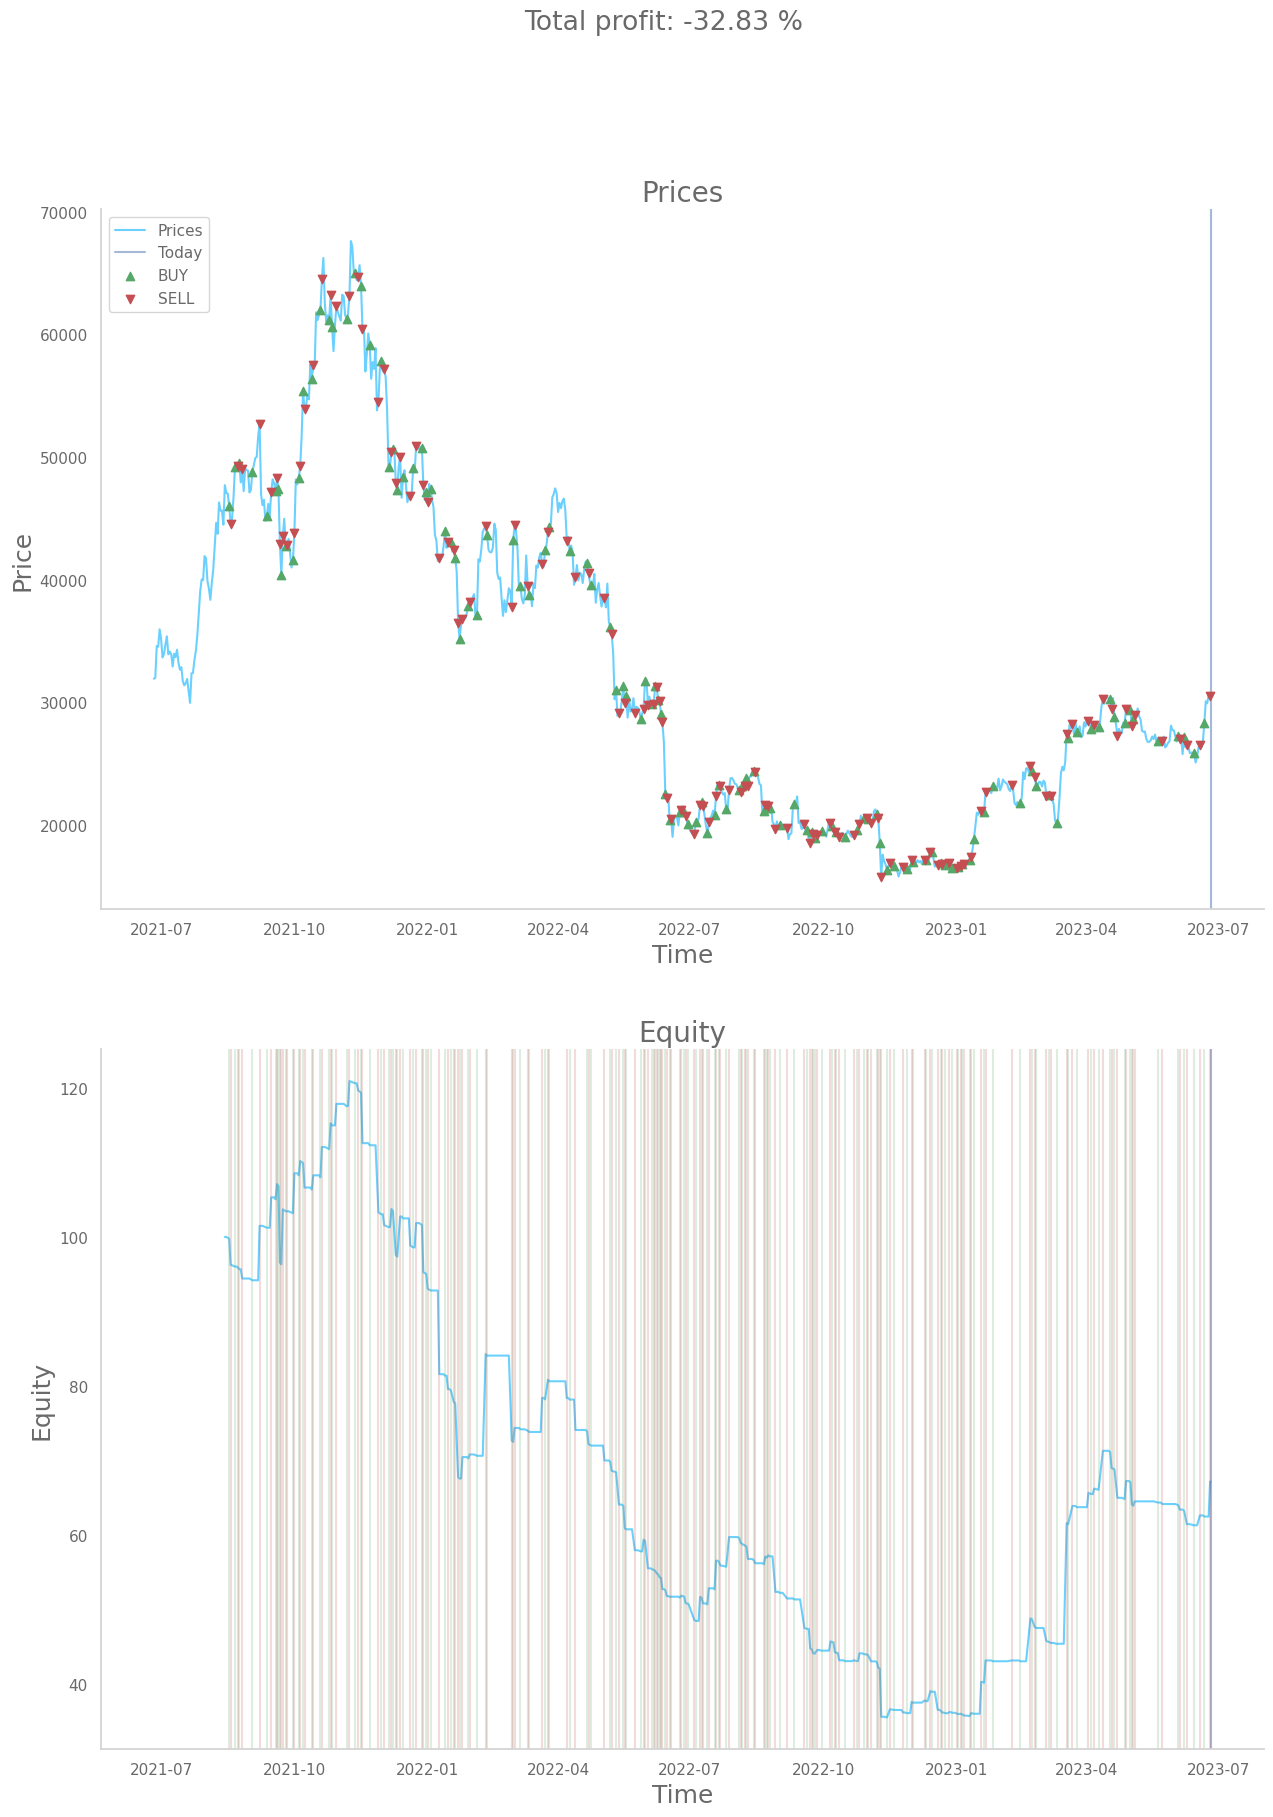

In [10]:
simulate(RandomAgent(), env)

Simulating a trading session with agent: MovingAverageCrossoverAgent


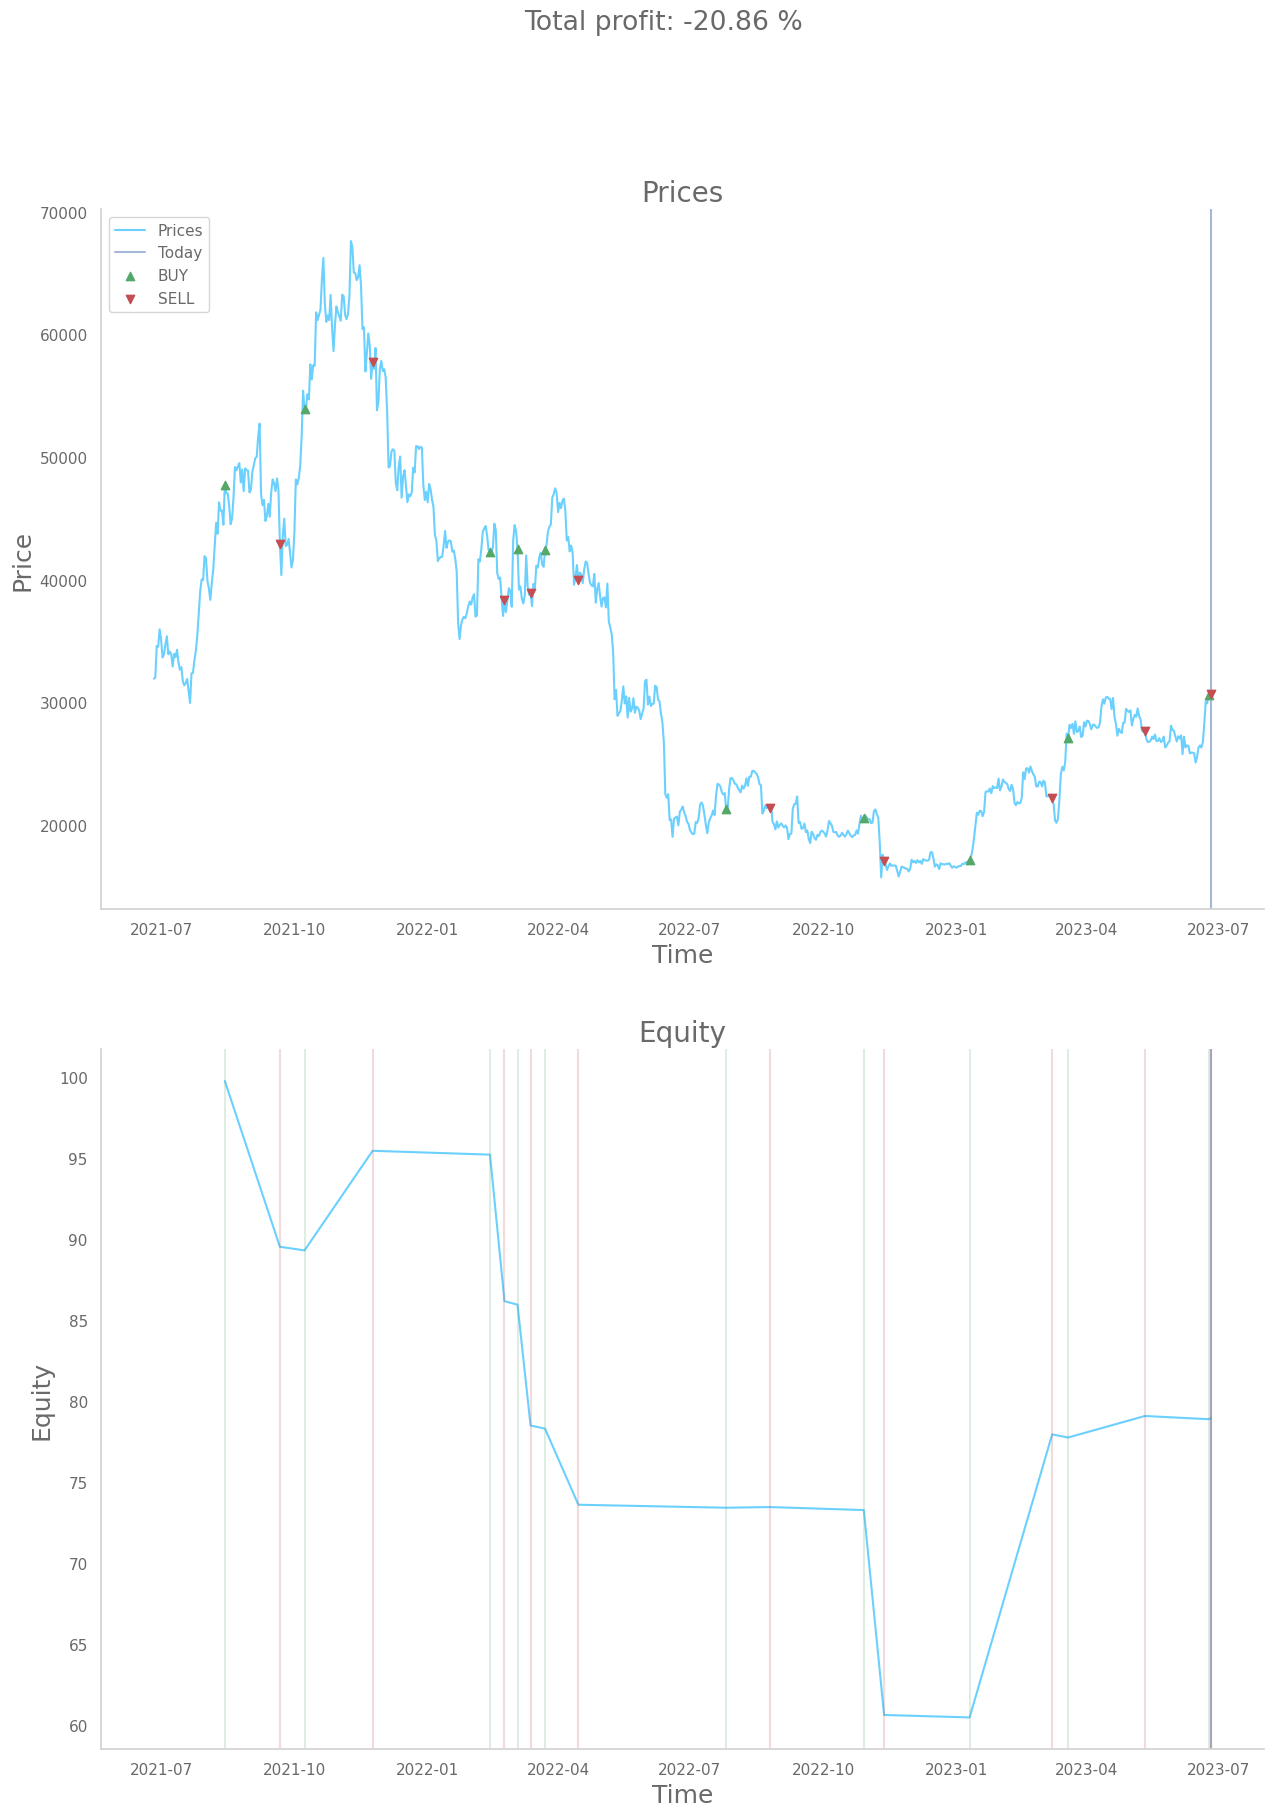

In [11]:
simulate(MovingAverageCrossoverAgent(), env)

Simulating a trading session with agent: BollingerBandsAgent


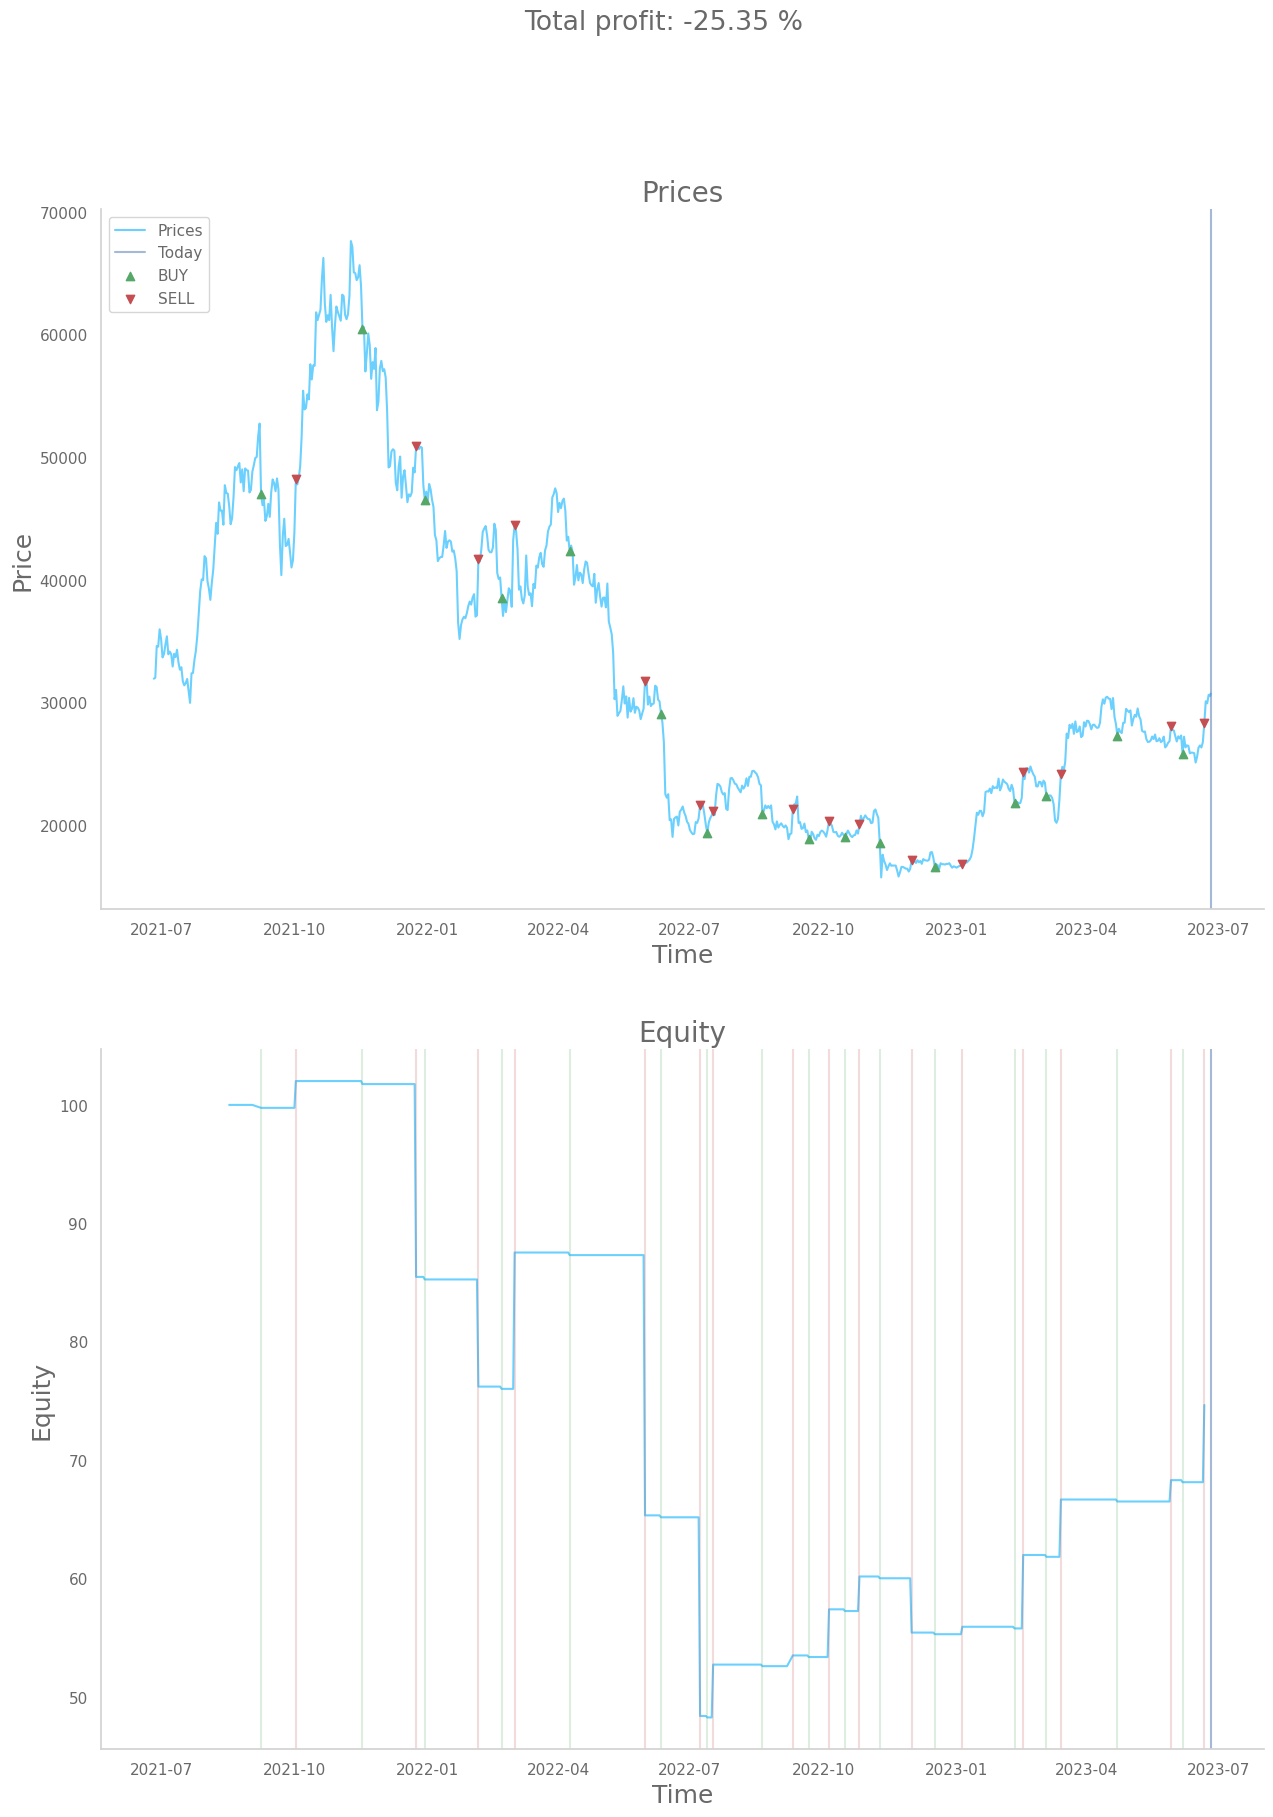

In [12]:
simulate(BollingerBandsAgent(), env)